In [1]:
from datetime import datetime
from glob import glob
import json
import os

import cv2
from keras import losses, Model, optimizers, metrics
from keras.callbacks import ModelCheckpoint
from keras.layers import Activation, Add, BatchNormalization, Concatenate, Conv2D, Dense, DepthwiseConv2D, Dropout, Flatten, Input, Reshape
from keras.losses import SparseCategoricalCrossentropy
# from keras.metrics import MeanSquaredError, SparseCategoricalAccuracy
from keras.utils import plot_model
from livelossplot import PlotLossesKeras, PlotLossesKerasTF
from matplotlib import pyplot as plt
from numpy import interp
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.preprocessing import label_binarize
import tensorflow as tf
import tensorflow.keras as k
from tensorflow.python.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.python.ops.image_ops_impl import *

from helper.dataset_mkr import *
from helper.eval_function import *
from helper.evaluate import *
from helper.gpu_memory import *
from helper.model import *
from helper.model_visualizer import *
from helper.tflite import *

2022-11-17 22:15:39.810999: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 22:15:39.935675: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-17 22:15:40.504728: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/z/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-11-17 22:15:40.504782: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dle

In [2]:
# load tensorboard
%load_ext tensorboard


In [3]:
"""
0 CPU
1 필요한 만큼 메모리를 런타임에 할당
2 GPU에 할당되는 전체 메모리 크기를 제한
"""
set_gpu_memory(1)

1 Physical GPUs, 1 Logical GPUs


2022-11-17 22:15:41.622839: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-17 22:15:41.627272: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-17 22:15:41.627522: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-17 22:15:41.628218: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [4]:
MODEL_VERSION = f"v2.1"
SAVE_PATH = f"OUT/{MODEL_VERSION}"

MIN, MAX = 0, 255

CLASS = 23
# RAW_CLASS = 23
# CLASS = RAW_CLASS+1  ## 1: BACKGROUND


# 1. DATASET

In [5]:
data_dir = f"/media/z/0/MVPC10/DATA/v1.1/RAW/03"
# file = f"label_1248_cnt.csv"
file = f"/media/z/0/MVPC10/DATA/LABEL/v2.1_FINAL_REFINED.csv"
df = pd.read_csv(file)
# df.sort_values(by=df.keys()[0], inplace=True, ascending=True)
print(df)


                path                                              label
0      1650315736806                                     [[0, 0, 0, 0]]
1      1650315796123                                     [[0, 0, 0, 0]]
2      1650315856514                                     [[0, 0, 0, 0]]
3      1650315917006                                     [[0, 0, 0, 0]]
4      1650315976418                                     [[0, 0, 0, 0]]
...              ...                                                ...
86493  1661954116964  [[25, 41, 40, 67], [38, 32, 50, 60], [54, 43, ...
86494  1661954176336                                     [[0, 0, 0, 0]]
86495  1661954236769                                     [[0, 0, 0, 0]]
86496  1661954296445                [[15, 19, 31, 40], [26, 7, 33, 23]]
86497  1661954356730                                 [[13, 18, 31, 37]]

[86498 rows x 2 columns]


In [6]:
df.empty

False

In [7]:
df.values[:,1].dtype

dtype('O')

In [8]:
df1 = v2_1_data_mkr(df, z_value=2)
df1.head

<bound method NDFrame.head of                 path  label
0      1650315796123      0
1      1650315917006      0
2      1650316036754      0
3      1650316156301      0
4      1650316276225      0
...              ...    ...
67461  1661954056432      9
67462  1661954116964      4
67463  1661954236769      0
67464  1661954296445      2
67465  1661954356730      1

[67466 rows x 2 columns]>

array([[<AxesSubplot:title={'center':'label'}>]], dtype=object)

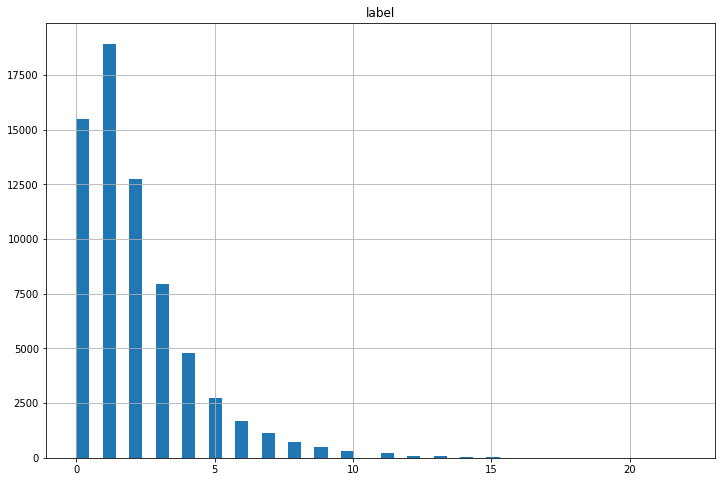

In [9]:
df1.hist(column="label", bins=CLASS*2, figsize=(12, 8))

In [10]:
df1['label'].value_counts().describe()

count       20.000000
mean      3373.300000
std       5772.821449
min          1.000000
25%         30.250000
50%        404.500000
75%       3258.250000
max      18938.000000
Name: label, dtype: float64

In [11]:
# df1.to_csv(f"test.csv", index=False)

### 1.2 AUGMENT

In [12]:
# ---------------------------------------------------------------- SHUFFLE DATA
SHUFFLE_DATA = 1
if SHUFFLE_DATA == 1:
    df1 = df1.sample(frac=1).reset_index(drop=True)
# df

In [13]:
## DROP ERROR
# df1 = df[df.iloc[:, 1] > 0]
# df1.head

### 1.4 DATA to TENSOR

In [14]:
data_full_path = f"/media/z/0/MVPC10/DATA/03_PROCESSED"

data, label = df_to_tensor(df1, data_full_path)

0
10000
20000
30000
40000
50000
60000


In [69]:
data = np.array(data)
data = data.reshape(data.shape[0], 80, 80, 1)
print(data.shape)

label = np.array(label)
label = label.reshape(label.shape[0], 1, 1, 1)
# label = label.reshape(label.shape[0], 1)
print(label.shape)

H, W = data.shape[1], data.shape[2]
print(H, W)


(67466, 80, 80, 1)
(67466, 1, 1, 1)
80 80


In [59]:
np.unique(label)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 21, 22])

### 1.5 PROCESS

In [60]:
# set(data.reshape(-1))


In [61]:
## ---------------------------------------------------------------- SHUFFLE
# seed = 99
# np.random.seed(seed)
# np.random.shuffle(data)
# # np.random.seed(seed)
# np.random.shuffle(label)

## ---------------------------------------------------------------- LABEL NORMALIZE
# norm_label = label/CLASS
norm_label = label  ## NO NORMALIZE
# norm_label.dtype

## ---------------------------------------------------------------- DATA NORMALIZE
# print(data[0][0])
norm_data = data/MAX
# norm_data = data.astype("float")/MAX
# print(norm_data[0][0])


## ---------------------------------------------------------------- SPLIT
split1 = int(len(label)*0.96)
X1, X2 = norm_data[:split1], norm_data[split1:]
Y1, Y2 = norm_label[:split1], norm_label[split1:]
## VAL SPLIT
split2 = int(len(label)*0.9)
# X1, val_data = X1[:split2], X1[split2:]
# X2, val_label = X2[:split2], X2[split2:]



In [62]:
print(X1.shape)
print(Y1.shape)
print(X2.shape)
print(Y2.shape)

(64767, 80, 80, 1)
(64767, 1)
(2699, 80, 80, 1)
(2699, 1)


# 2. TRAIN

In [72]:
def bottleneck(name, input, filter=32, size0=3, size1=3, stride=1, padding='same', activation='elu', dropout=0.25):
    skip = Conv2D(filter, size0, strides=stride, padding=padding, activation=activation, name=f"{name}_SKIP")(input)
    if padding == 'valid':
        input = Conv2D(filter, size0, strides=stride, padding=padding, activation=activation, name=f"{name}_C0")(input)
        stride = 1
    x = Conv2D(filter*2, 1, strides=stride, padding='same', activation=activation, name=f"{name}_C")(input)
    x = DepthwiseConv2D(size1, padding='same', activation=activation, name=f"{name}_DW_C")(x)
    x = Conv2D(filter, 1, 1, padding='same', name=f"{name}_PW_C")(x)
    x = Dropout(dropout, name=f"{name}_DO0")(x)
    a = Add(name=f"{name}_ADD")([skip, x])
    return a


def bottleneck1(input, filter=32, size0=3, size1=3, stride=1, padding='same', activation='elu', dropout=0.25):
    skip = Conv2D(filter, size0, strides=stride, padding=padding, activation=activation)(input)
    if padding == 'valid':
        input = Conv2D(filter, size0, strides=stride, padding=padding, activation=activation)(input)
        stride = 1
    x = Conv2D(filter*2, 1, strides=stride, padding='same', activation=activation)(input)
    x = DepthwiseConv2D(size1, padding='same', activation=activation)(x)
    x = Conv2D(filter, 1, 1, padding='same')(x)
    x = Dropout(dropout)(x)
    a = Add()([skip, x])
    return a

In [74]:
TUNER = 0

LOAD_MODEL = 0
model_num = -1
compile = 1

MODEL_NAME = f"mobileNet"
TIME = f"{datetime.now().strftime('%Y%m%d-%H%M%S')}"

## -------------------------------------------------------------------------------- MODEL
if LOAD_MODEL == 0:
    # if TUNER == 1:
    #     def build_model(hp):
    #         filter = hp.Choice('filter', values=[16, 32, 64, 128, 256])
    #         size = hp.Choice('size', values=[3, 5, 7, 9, 11])
    #         stride = hp.Choice('stride', values=[1, 2])
    ## ---------------------------------------------------------------- SETUP
    """
    size = input_shape - layer_shape + 1
    con(filter, (size), stride, padding, activation, name, input)
    bottleneck(name, input, filter=32, size0=3, size1=3, stride=2, activation='elu', dropout=0.25)
    """
    inc = make_inc()

    ## ---------------------------------------------------------------- HEAD
    input = Input(shape=(H, W, 1))
    x = bottleneck(f'{inc()}', input, 64, 3, 3, 2, 'valid', 'swish', 0.25)

    ## ---------------------------------------------------------------- BODY
    x = bottleneck(f'{inc()}', x, 64, 3, 3, 1, 'valid', 'swish', 0.25)
    x = bottleneck(f'{inc()}', x, 64, 3, 3, 1, 'valid', 'swish', 0.25)
    x = bottleneck(f'{inc()}', x, 64, 3, 3, 1, 'valid', 'swish', 0.25)
    x = bottleneck(f'{inc()}', x, 64, 3, 3, 1, 'valid', 'swish', 0.25)
    x = bottleneck(f'{inc()}', x, 32, 3, 3, 1, 'valid', 'swish', 0.25)
    x = bottleneck(f'{inc()}', x, 16, 3, 3, 1, 'valid', 'swish', 0.25)
    x = bottleneck(f'{inc()}', x, 16, 3, 3, 1, 'valid', 'swish', 0.25)
    x = bottleneck(f'{inc()}', x, 8, 3, 3, 1, 'valid', 'swish', 0.25)
    x = bottleneck(f'{inc()}', x, 4, 3, 3, 1, 'valid', 'swish', 0.25)
    x = bottleneck(f'{inc()}', x, 2, 3, 3, 2, 'valid', 'swish', 0.25)

    # x = res_block(64, 3, 1, 'valid', 'elu', 0.25, f'{inc()}', x)
    # x = res_block(64, 3, 1, 'valid', 'elu', 0.25, f'{inc()}', x)
    # x = res_block(32, 3, 1, 'valid', 'elu', 0.25, f'{inc()}', x)
    # x = res_block(32, 3, 1, 'valid', 'elu', 0.25, f'{inc()}', x)
    # x = res_block(16, 11, 1, 'valid', 'elu', 0.25, f'{inc()}', x)
    # x = res_block(8, 13, 1, 'valid', 'elu', 0.25, f'{inc()}', x)

    ## ---------------------------------------------------------------- TAIL
    # x = tf.reduce_mean(x, (1, 2))  #, axis=None, keepdims=False, name=None)
    # x = Conv2D(1, x.shape[1]//2, strides=2, name=f'{inc()}')(x)
    x = Dropout(.5)(x)
    output = Conv2D(1, x.shape[1], strides=2)(x)

    model = Model(input, output)
    # return model

elif LOAD_MODEL == 1:
    model_name = sorted(glob(f"{SAVE_PATH}/model/*.h5"))[model_num]
    print(f"model_path_last: {model_name}")
    model = tf.keras.models.load_model(model_name, compile=compile)

## -------------------------------------------------------------------------------- COMPILE
## ---------------------------------------------------------------- OPTIMIZER
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.0001,
                                                             decay_steps=100000,
                                                             decay_rate=0.96,
                                                             staircase=True)
# lr_schedule = k.optimizers.schedules.CosineDecay(initial_learning_rate=1e-4,
#                                                  decay_steps=EPOCH,)
optimizer = optimizers.Adam(learning_rate=lr_schedule)

# optimizer = optimizers.Adam(learning_rate=0.0001)

## ---------------------------------------------------------------- LOSS
# def adaptive_loss():
#     pass
# loss = losses.MeanAbsoluteError()
# loss = losses.BinaryCrossentropy()
loss = losses.MeanSquaredError()
# loss = losses.SparseCategoricalCrossentropy()
# loss = losses.BinaryFocalCrossentropy(  #apply_class_balancing=False,
# alpha=0.25,
# gamma=2.0,
# from_logits=False,
# label_smoothing=0.0,
# axis=-1,
# reduction=losses_utils.ReductionV2.AUTO,
# name='binary_focal_crossentropy'
# )

## ---------------------------------------------------------------- METRICS
metrics = ['accuracy']
# metrics = [SparseCategoricalAccuracy]
# metrics = [metrics.MeanSquaredError()]

## ---------------------------------------------------------------- COMPILE
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

model.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 80, 80, 1)]  0           []                               
                                                                                                  
 conv2d_49 (Conv2D)             (None, 39, 39, 64)   640         ['input_19[0][0]']               
                                                                                                  
 conv2d_50 (Conv2D)             (None, 39, 39, 128)  8320        ['conv2d_49[0][0]']              
                                                                                                  
 depthwise_conv2d_11 (Depthwise  (None, 39, 39, 128)  1280       ['conv2d_50[0][0]']              
 Conv2D)                                                                                   

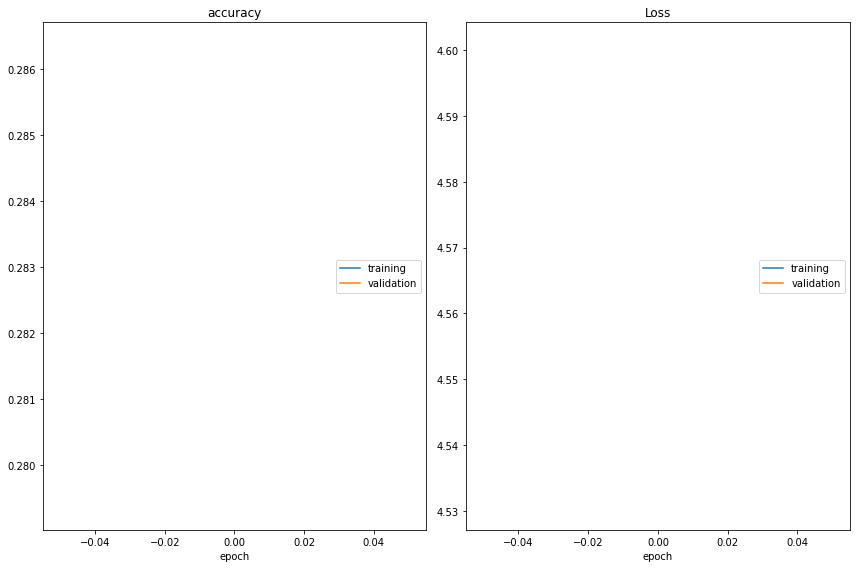

accuracy
	training         	 (min:    0.279, max:    0.279, cur:    0.279)
	validation       	 (min:    0.286, max:    0.286, cur:    0.286)
Loss
	training         	 (min:    4.601, max:    4.601, cur:    4.601)
	validation       	 (min:    4.531, max:    4.531, cur:    4.531)
911/911 [==============================] - 74s 79ms/step - loss: 4.6007 - accuracy: 0.2794 - val_loss: 4.5306 - val_accuracy: 0.2864


In [75]:
## ---------------------------------------------------------------- INIT
EPOCH = 1
BATCH = 64
# ES = 4
ES = EPOCH//2

## ---------------------------------------------------------------- CALLBACK
earlyStop = EarlyStopping(patience=ES, monitor='val_loss', mode='auto', verbose=1)
tensorBoard = TensorBoard(log_dir=f"{SAVE_PATH}/log/{TIME}", histogram_freq=1)
checkPoint = ModelCheckpoint(f"{SAVE_PATH}/model/{TIME}_{MODEL_NAME}_ckpt.h5",  ## _{epoch:02d}-{val_loss:.2f},
                             save_best_only=True, verbose=1, save_freq='epoch',
                             monitor='val_accuracy',  ## 'loss', 'val_accuracy', 'val_loss'
                             mode='max')
## ---------------------------------------------------------------- FIT
if TUNER == 0:
    history = model.fit(X1, Y1,
                        validation_split=0.1,
                        # validation_data=(val_data, val_label),
                        batch_size=BATCH,
                        epochs=EPOCH,
                        use_multiprocessing=True,
                        verbose=1,
                        callbacks=[earlyStop,
                                   tensorBoard,
                                   checkPoint,
                                   PlotLossesKeras(),
                                   # PlotLossesKerasTF(),
                                   ],
                        )

In [ ]:
## ---------------------------------------------------------------- TUNER
if TUNER == 1:
    import keras_tuner as kt

    # tuner = kt.RandomSearch(build_model,
    #                         objective='val_loss',
    #                         max_trials=5)
    tuner = kt.Hyperband(build_model,
                         objective='val_accuracy',
                         max_epochs=EPOCH,
                         factor=3,
                         directory=f'{SAVE_PATH}/tuner',
                         )
    tuner.search(X1, Y1,
                 validation_split=0.1,
                 # validation_data=(x_val, y_val),
                 batch_size=BATCH,
                 epochs=EPOCH,
                 use_multiprocessing=True,
                 verbose=1,
                 callbacks=[earlyStop,
                            checkPoint,
                            tensorBoard,
                            PlotLossesKeras(),
                            # PlotLossesKerasTF(),
                            ],
                 )
    # best_model = tuner.get_best_models()[0]
    best_hps = tuner.get_best_hyperparameters(num_trials=2)[0]
    model = tuner.hypermodel.build(best_hps)

In [ ]:
# weight_visualizer(model, 0, -1)

# filter_visualizer(model, X2[2])

### 2.3 VISUALIZE LAYER

In [ ]:
conv_layers1 = []
for i in model.layers:
    if 'C2' in i.output:
        print()
        # conv_layers1.append(i.output)
conv_layers1


In [ ]:
a = model.get_layer('8_C2').output
a

In [ ]:
conv_layer_index = [1, 5, 9, 13]
conv_layers = [model.layers[i].output for i in conv_layer_index]
# conv_layers = [i.output for i in model.layers if "C2" in i.name][:1]
print(conv_layers)

In [ ]:
visualize_model = Model(model.inputs, conv_layers)
print(visualize_model.summary())

In [ ]:
for i in range(20, 100, 10):
    img = X2[i]
    re_img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
    conv_img = visualize_model.predict(re_img)
    # columns = int(round(np.sqrt(model.shape[1])))
    # rows = int(round(np.sqrt(model.shape[2])))
    columns = 8
    rows = 8
    for c_img in conv_img:
        # pos = 1
        fig = plt.figure(figsize=(12, 12))
        for i in range(1, columns*rows+1):
            fig = plt.subplot(rows, columns, i)
            fig.axis('off')
            plt.imshow(c_img[:, :, i-1], cmap='gray')
            # pos += 1
        # plt.show()

In [ ]:
filter_visualizer(model, data[0])

In [ ]:
# visual_keras(model, MODEL_VERSION)
model_visualizer(model, data[0])

In [ ]:
# TENSORBOARD == 1
# if TENSORBOARD == 1:
#     launch tensorboard @ localhost:6006
#     %tensorboard --logdir logs/--host localhost --port 6006
# %tensorboard --logdir={log_path}

In [ ]:
## history to DF
hdf = pd.DataFrame(history.history)
hdf.keys()

## plot history
hdf.plot(figsize=(9, 6), grid=1, xlabel="epoch", label="accuracy")
plt.ylim([0, 2])
plt.show()


In [ ]:
SAVE_MODEL_PLOT = 0
if SAVE_MODEL_PLOT == 1:
    plot_model(model, to_file=f"{SAVE_PATH}/plot/{TIME}.png", show_shapes=True, show_layer_names=False, show_layer_activations=True)


# 3. EVALUATE

In [25]:
loss, acc = model.evaluate(X2, Y2, verbose=1)

predict = model.predict(X2)


85/85 [==============================] - 2s 12ms/step


In [26]:
## ---------------------------------------------------------------- OUPUT CONVERT
predict_0 = np.reshape(predict, predict.shape[0])
Y2_0 = np.reshape(Y2, Y2.shape[0])
print(predict_0.shape)
print(Y2_0.shape)

(2699,)
(2699,)


In [27]:
BIAS = v2_1_bias_finder(Y2_0, predict_0, -0.10, 0.10, 0.01)

v2_1_accuracy_calculator(Y2_0, predict_0, BIAS)


(-0.1, 882)
(-0.09, 884)
(-0.08, 882)
(-0.07, 883)
(-0.06, 883)
(-0.05, 880)
(-0.04, 879)
(-0.03, 878)
(-0.02, 879)
(-0.01, 879)
(-0.0, 876)
(0.01, 876)
(0.02, 878)
(0.03, 874)
(0.04, 875)
(0.05, 877)
(0.06, 878)
(0.07, 884)
(0.08, 892)
(0.09, 894)

BIAS: 0.03
error: 874
total: 5412
acc:   84.0%


In [ ]:
# df2 = df1.iloc[:, 0][split1:]
df2.iloc[-1]

In [ ]:
def save_result_to_csv(X, Y, P):
    result_list = []
    df2 = df1.iloc[:, 0][split1:]
    n = len(X)
    for i in range(0, n, 1):
        predict = round(P[i])
        diff = abs(predict-Y[i])
        result_list.append([df2.iloc[i], Y[i], predict, diff])

    return result_list

result_list = save_result_to_csv(X2, Y2_0, predict_0)
result_list


In [ ]:
import csv

with open('v2.1_result.csv', 'w') as f:
    write = csv.writer(f)
    write.writerow(['data', 'label', 'predict', 'difference'])
    write.writerows(result_list)

In [ ]:
v2_1_view_samples1(X2, Y2_0, predict_0, thresh=10)


## 4. TFLITE

In [76]:
def representative_dataset():
    for i in range(100):
        a = np.reshape(X2[i], (1, X2.shape[1], X2.shape[2], 1))
        yield [a.astype(np.float32)]


def save_to_tflite1(model, model_save_name, quantize=0, dataset=None):
    # converter = tf.lite.TFLiteConverter.from_saved_model(model_path_last)
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    if quantize == 8:
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        converter.representative_dataset = representative_dataset
        converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
        converter.inference_input_type = tf.uint8  # or tf.int8
        converter.inference_output_type = tf.uint8  # or tf.int8
    elif quantize == 16:
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_model = converter.convert()
    with open(f'{model_save_name}.tflite', 'wb') as f:
        f.write(tflite_model)


model_save_name = f"{SAVE_PATH}/model/{TIME}_{MODEL_NAME}"

TFLITE = 1
if TFLITE == 1:
    # SAVE_PATH = f"../OUT/v2.1/model"
    # model_num = -1
    # model_path_last = sorted(glob(f"{SAVE_PATH}/model/*.h5"))[model_num]
    # model = tf.keras.models.l oad_model(model_path_last)
    # model_save_name = f"{SAVE_PATH}/model/new_model.tflite"
    save_to_tflite1(model, model_save_name)

INFO:tensorflow:Assets written to: /tmp/tmpyc1h6vx5/assets


INFO:tensorflow:Assets written to: /tmp/tmpyc1h6vx5/assets
2022-11-18 12:05:20.010078: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-18 12:05:20.010103: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-18 12:05:20.010216: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpyc1h6vx5
2022-11-18 12:05:20.027413: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-18 12:05:20.027442: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpyc1h6vx5
2022-11-18 12:05:20.088718: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-18 12:05:20.420810: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpyc1h6vx5
2022-11-18 12:05:20.509318: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

In [ ]:
output_li = [round(int(inference_v2_1(tflite_name, i, 'uint8'))/CLASS) for i in X2]

In [ ]:
BIAS = v2_1_bias_finder(Y2_0, output_li, -0.10, 0.10, 0.01)

v2_1_accuracy_calculator(Y2_0, output_li, BIAS)


In [ ]:
v2_1_view_samples1(X2, Y2_0, output_li, thresh=10)

In [ ]:
# BATCH = 32
# EPOCH = 30
#
# lb = Y2.reshape(-1)
# has = {}
#
# # np.array(list(set(Y2.reshape(-1)))).astype(np.int64)
# ls_num = list(map(int, list(set(lb))))
# for n in ls_num:
#     has[n] = []
# for ind in range(len(lb)):
#     # ind는 label 인덱스
#     if len(has[lb[ind]]) < 30:
#         has[lb[ind]].append(ind)
#
# x_data = []
# y_data = []
# for key in has.keys():
#     for ind in has[key]:
#         x_data.append(Y1[ind])
#         y_data.append(Y2[ind])
#
# x_data = np.array(x_data).astype(np.float32)
# y_data = np.array(y_data).astype(np.float32)
# X1 = X1.astype(np.float32)
# X2 = X2.astype(np.float32)
#
# for i in range(30):
#     print(i)
#     history = model.fit(X1, X2,
#                         # validation_split=0.2,
#                         validation_data=(x_data, y_data),
#                         batch_size=BATCH,
#                         epochs=EPOCH,
#                         verbose=1,
#                         # callbacks=[es],)
#                         # callbacks=[es, tensorboard_callback], )
#                         )
#     model.save('asdf/' + str(i) + '.h5')

In [ ]:
# epo = 10
# model = tf.keras.models.load_model('asdf/' + str(epo) + '.h5')
# Y2.shape
#
# lb = Y2.reshape(-1)
# has = {}
#
# # np.array(list(set(Y2.reshape(-1)))).astype(np.int64)
#
#
# ls_num = list(map(int, list(set(lb))))
# for n in ls_num:
#     has[n] = []
#
# for ind in range(len(lb)):
#
#     # ind는 label 인덱스
#
#     if len(has[lb[ind]]) < 30:
#         has[lb[ind]].append(ind)
#
# ls_num
#
# x_data = []
# y_data = []
#
#
# for key in has.keys():
#     for ind in has[key]:
#         x_data.append(Y1[ind])
#         y_data.append(Y2[ind])
#
# x_data = np.array(x_data)
# y_data = np.array(y_data)
# x_data.shape
# y_data.shape
#
#
# result = np.argmax(model.predict(x_data), -1)
# cont = 0
# for ind in range(len(result)):
#     if result[ind] == y_data.reshape(-1)[ind]:
#         cont +=1
#
#
# cont
# print(len(ls_num))
# print(cont/len(result))
